# Single Peak Simulations

This notebook tests FOOOF's performance on simulated power spectra.

In [1]:
%matplotlib inline

In [2]:
import pickle

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

#from fooof import FOOOF
from fooof import FOOOFGroup, fit_fooof_group_3d
#from fooof.plts import plot_spectrum
#from fooof.sim import gen_power_spectrum
from fooof.sim import gen_group_power_spectra

In [3]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from settings import *
from utils import *
from plts import *

## Settings

In [4]:
# Set random seed
import random
random.seed(333)

In [5]:
# Set plotting style from seaborn
sns.set_style('white')

In [6]:
# Analysis Settings
SAVE_FIG = False
GEN_SIMS = True

## Simulation Tests: One Peak Across Noise Levels

First, simulate power spectra with one peak, and measure how well we can reconstruct each variable.

### Simulate Power Spectra

In [7]:
# Set the number of PSDs - this is per noise condition
n_psds = 1000

# Set the noise levels to use
nlvs = [0.0, 0.025, 0.050, 0.10, 0.15]

# Use generators to sample peak & aperiodic parameters
peaks = gen_osc_def(1)
aps = gen_ap_def()

In [8]:
# Get data sizes
n_nlvs = len(nlvs)
n_freqs = int((F_RANGE[1] - F_RANGE[0]) / F_RES + 1)

In [9]:
# Generate or load power spectra
data_name = 'single_peak_sims'

if GEN_SIMS:
    
    # Initialize data stores
    freqs = np.empty(shape=n_freqs)
    psds = np.empty(shape=[n_nlvs, n_psds, n_freqs])
    op_sim_params = [None] * n_nlvs

    # Generate simulated power spectra
    for n_ind, nlv in enumerate(nlvs):
        freqs, psds[n_ind, :, :], op_sim_params[n_ind] = \
            gen_group_power_spectra(n_psds, F_RANGE, aps, peaks, nlv, F_RES)
    
    # Save out generated simulations & parameter definitions
    np.savez(DATA_PATH + data_name + '.npz', freqs, psds)
    with open(DATA_PATH + data_name + '.p', 'wb') as f_obj:
        pickle.dump(op_sim_params, f_obj)

else:
    
    # Load previously generated simulations & parameter definitions
    temp = np.load(DATA_PATH + data_name + '.npz')
    freqs, psds = temp['arr_0'], temp['arr_1']
    with open(DATA_PATH + data_name + '.p', 'rb') as f_obj:
        op_sim_params = pickle.load(f_obj)
        
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

n_nlvs, n_spectra, n_freqs :  (5, 1000, 153)


In [10]:
# Extract ground truth values
osc_truths, ap_truths = get_ground_truth(op_sim_params)

##### Check the empirical levels of noise expected  (empirical noise floor)

These should be, and are, the same as the noise scaling factor. This just checks the estimate error on that, given the number of simulations. These values then set the amount of variance that can be expected to be captured by FOOOF - and if it captures more than this, we know that it is overfitting. 

In [12]:
emp_nlv = []
for nlv in nlvs:
    temp = []

    # Within each noise level, get the average squared 'error'
    for it in range(n_psds):
        temp.append(np.mean(np.random.normal(0, nlv, len(freqs))**2))
    
    # Get the average 'error' per noise level
    emp_nlv.append(np.mean(temp))

In [13]:
# Compare simulated values to empirical values
print('Simulated NLV Values:')
print_list(nlvs)
print('Empirical NLV Values:')
print_list(np.sqrt(emp_nlv))

Simulated NLV Values:
['0.0000', '0.0250', '0.0500', '0.1000', '0.1500']
Empirical NLV Values:
['0.0000', '0.0250', '0.0501', '0.0999', '0.1500']


### Fit Power Spectra with FOOOF

In [14]:
# Initialize FOOOFGroup to test with
op_fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, verbose=False)

# Print out settings used for fitting simulated power spectra - one peak
op_fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 6]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.0                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : fixed                                      
                                                                                                  


In [15]:
# Fit power spectra - same FOOOF settings across each group of simulated power spectra
op_fgs = fit_fooof_group_3d(op_fg, freqs, psds)

In [16]:
# # Alternatively:
# # Fit power spectra - adapting FOOOF settings for each group of simulated power spectra
# fgs = []
# for nlv, nlv_psds in zip(nlvs, psds):
#     fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_height=5*nlv)
#     fg.fit(freqs, nlv_psds)
#     fgs.append(fg.copy())

### Extract FOOOF fit Data

In [17]:
# Extract data of interest from FOOOF fits
osc_fits, ap_fits, err_fits, r2_fits, n_oscs = get_fit_data(op_fgs)

In [18]:
# Calculate error
osc_errors = np.abs(osc_truths - osc_fits) # absolute deviation
ap_errors = np.abs(ap_truths - ap_fits)

#osc_errors = (osc_truths - osc_fits)**2   # squared error
#ap_errors = (ap_truths - ap_fits)**2

In [19]:
# Pull out error per oscillations parameter
cf_errors = osc_errors[:, :, 0]
pw_errors = osc_errors[:, :, 1]
bw_errors = osc_errors[:, :, 2]

# Pull out error per aperiodic parameter
off_errors = ap_errors[:, :, 0]
exp_errors = ap_errors[:, :, 1]

### Check Average Errors & Stats

In [20]:
datas = [cf_errors, pw_errors, bw_errors, off_errors, exp_errors, err_fits, r2_fits]
labels = ['CF', 'PW', 'BW', 'OFF', 'EXP', 'ERR', 'R^2']
for dat, label in zip(datas, labels):
    print(label)
    print('\t', np.nanmedian(dat, 1))

CF
	 [0.00654238 0.17556063 0.39590366 0.72099476 1.04059567]
PW
	 [0.00274338 0.01331757 0.02438873 0.04919399 0.09956256]
BW
	 [0.05752194 0.23664164 0.5        0.87177709 1.        ]
OFF
	 [0.00188457 0.01348029 0.02464884 0.05150995 0.08147058]
EXP
	 [0.0014749  0.01134617 0.02085648 0.04024791 0.06183872]
ERR
	 [0.00133479 0.01926395 0.03843549 0.07733067 0.11618359]
R^2
	 [0.9999778  0.99700153 0.98653026 0.94164182 0.8924144 ]


In [21]:
print('Correlations of median error with noise level:')
print('\tCF\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(nlvs, np.nanmedian(cf_errors, axis=1))))
print('\tPW\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(nlvs, np.nanmedian(pw_errors, axis=1))))
print('\tBW\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(nlvs, np.nanmedian(bw_errors, axis=1))))
print('\tOFF\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(nlvs, np.nanmedian(off_errors, axis=1))))
print('\tEXP\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(nlvs, np.nanmedian(exp_errors, axis=1))))

Correlations of median error with noise level:
	CF	: 1.000 	0.00
	PW	: 1.000 	0.00
	BW	: 1.000 	0.00
	OFF	: 1.000 	0.00
	EXP	: 1.000 	0.00


### Create Plots

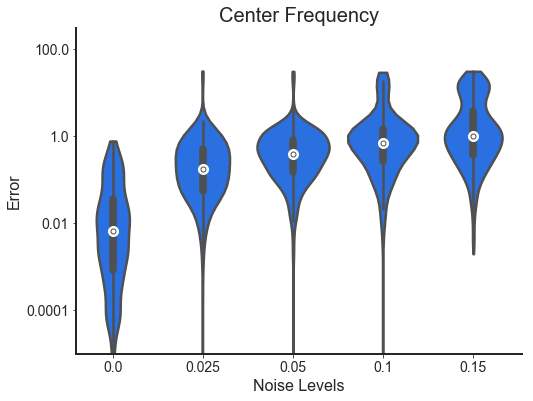

In [23]:
# Plot the error of oscillation center frequency reconstruction
plot_errors_violin(cf_errors, 'Center Frequency',
                   plt_log=True, y_label=None, ylim=[-5, 2.5],
                   save_fig=SAVE_FIG, save_name='1Peak-CF')

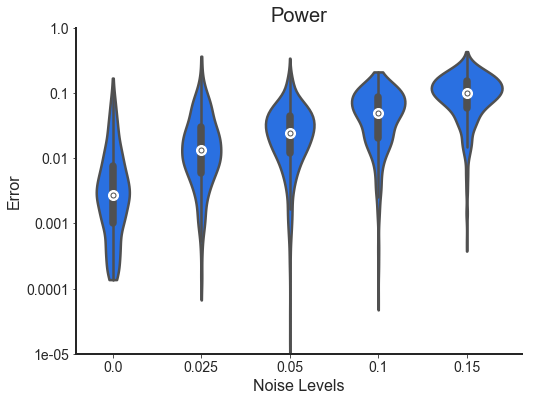

In [24]:
# Plot the error of oscillation power reconstruction
plot_errors_violin(pw_errors, 'Power',
                   plt_log=True, y_label=None, ylim=[-5, 0],
                   save_fig=SAVE_FIG, save_name='1Peak-PW')

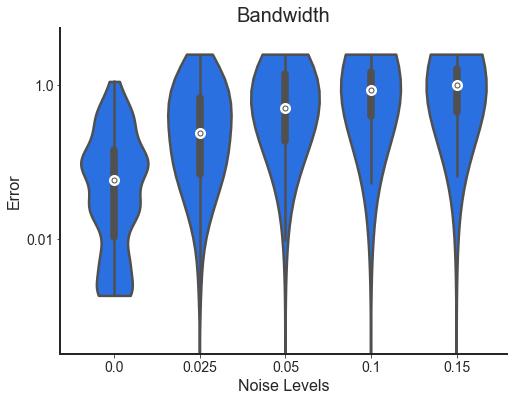

In [25]:
# Plot the error of oscillation bandwidth reconstruction
plot_errors_violin(bw_errors, 'Bandwidth',
                   plt_log=True, y_label=None, ylim=[-3.5, 0.75],
                   save_fig=SAVE_FIG, save_name='1Peak-BW')

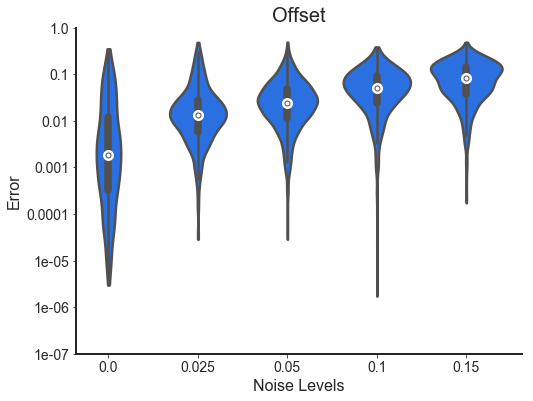

In [26]:
# Plot the error of aperiodic offset reconstruction
plot_errors_violin(off_errors, 'Offset',
                   plt_log=True, y_label=None,
                   save_fig=SAVE_FIG, save_name='1Peak-Off')

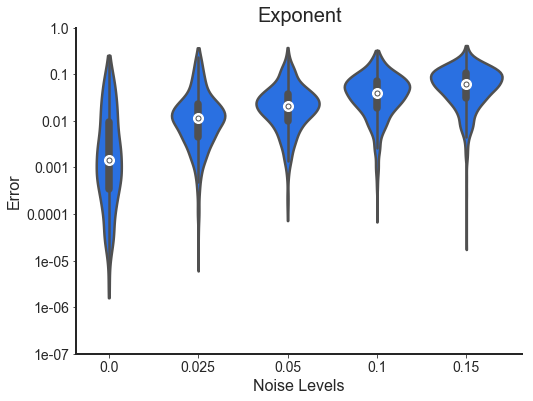

In [27]:
# Plot the error of aperiodic exponent reconstruction
plot_errors_violin(exp_errors, 'Exponent',
                   plt_log=True, y_label=None,
                   save_fig=SAVE_FIG, save_name='1Peak-Exp')

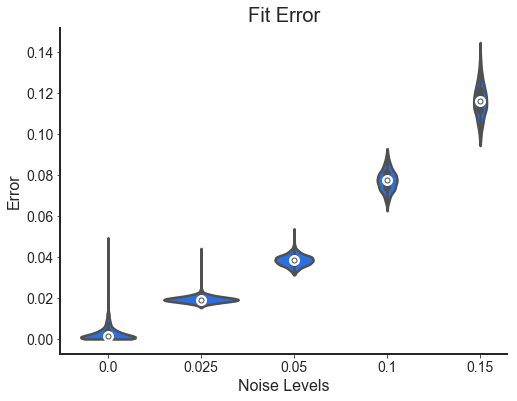

In [28]:
# Plot the amount of error across noise levels
plot_errors_violin(err_fits, 'Fit Error', plt_log=False,
                   y_label='Error',
                   save_fig=SAVE_FIG, save_name='1Peak-Err')

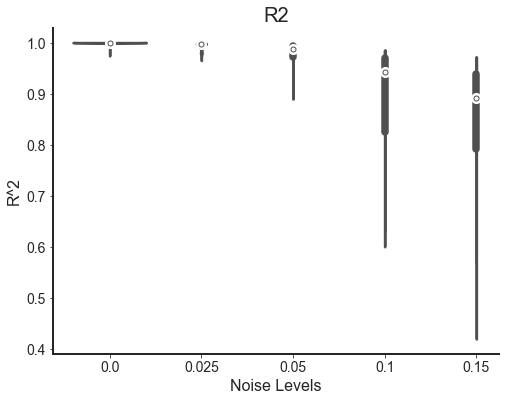

In [29]:
# Plot the goodness-of-fit (R^2) across noise levels
plot_errors_violin(r2_fits, 'R2', y_label='R^2', plt_log=False,
                   save_fig=SAVE_FIG, save_name='1Peak-R2')

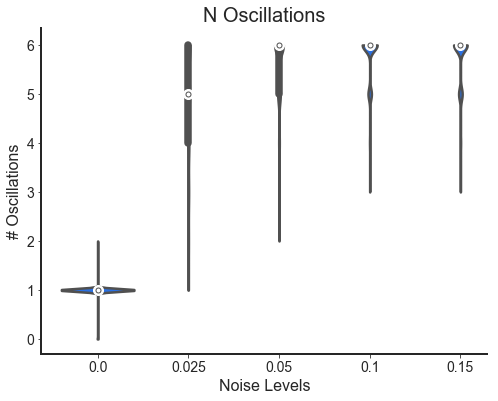

In [30]:
# Plot the number of fit oscillations across noise levels
plot_errors_violin(n_oscs, 'N Oscillations', y_label='# Oscillations', 
                   save_fig=SAVE_FIG, save_name='1Peak_#Oscs')

In [31]:
# Explore fitting linear model across noise levels, checking the slope and fit error

# from scipy.stats import spearmanr
# from scipy.stats import linregress

# nlvs_cont = np.array([nlv * np.ones(shape=[1, 1000]) for nlv in nlvs]).flatten()
# temp = cf_errors.flatten()
# keep_inds = ~np.isnan(temp)

# slope, intercept, r_value, p_value, std_err = linregress(nlvs_cont[keep_inds],
#                                                          temp[keep_inds])
# print(r_value**2)

# Explore checking the correlation of median error with noise levels
# print(spearmanr(nlvs, np.nanmedian(cf_errors, 1)))

### Example FOOOF Fits

SimParams(aperiodic_params=[0, 0.5], gaussian_params=[[10, 0.4, 1.0]], nlv=0.0)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.0010, 0.5006                                          
                                                                                                  
                             

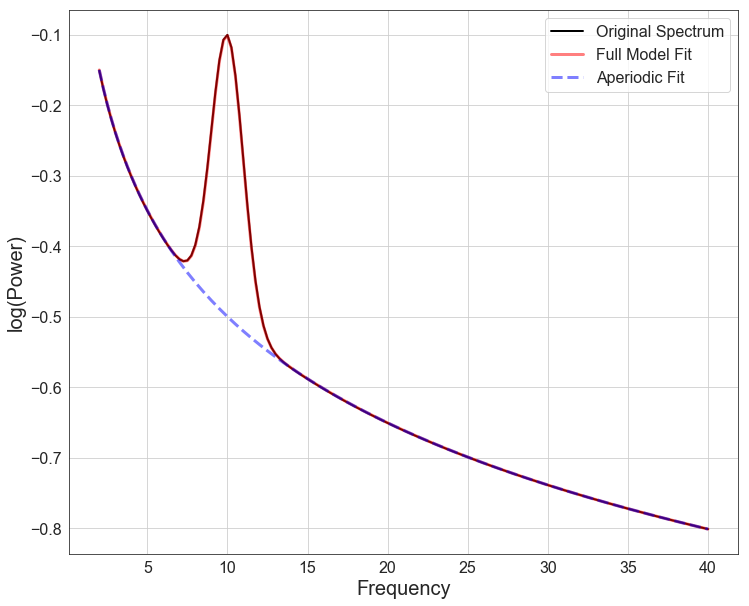

In [33]:
# Grab example cases - low noise
ind = 0
fm_nlv1 = op_fgs[0].get_fooof(ind, True)
print(op_sim_params[0][ind])
fm_nlv1.print_results()
fm_nlv1.plot(save_fig=SAVE_FIG, file_path=FIGS_PATH, file_name='1Peak-NLV1')

SimParams(aperiodic_params=[0, 1.0], gaussian_params=[[7, 0.2, 3.0]], nlv=0.15)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.0351, 1.0804                                          
                                                                                                  
                             

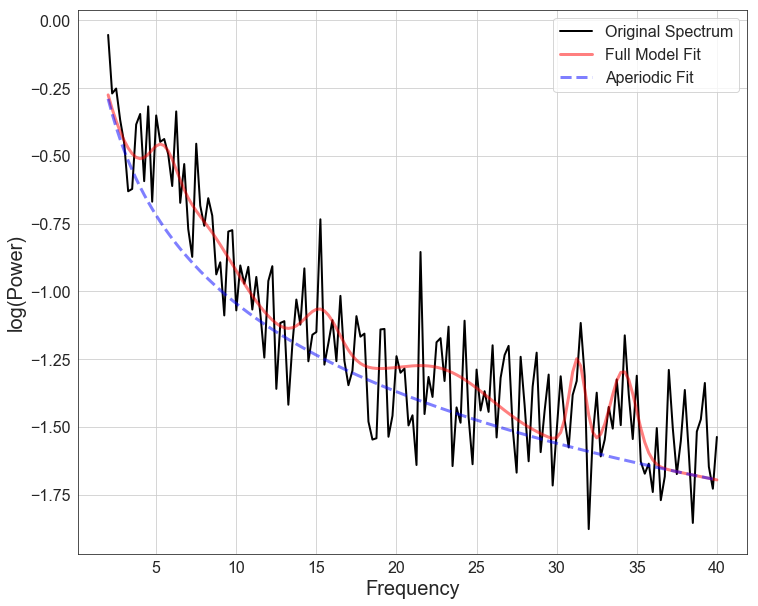

In [34]:
# Grab example cases - high noise
ind = 0
fm_nlv5 = op_fgs[-1].get_fooof(ind, True)
print(op_sim_params[-1][ind])
fm_nlv5.print_results()
fm_nlv5.plot(save_fig=SAVE_FIG, file_path=FIGS_PATH, file_name='1Peak-NLV5')

### Check Fit Qualities

In [35]:
temp = r2_fits.flatten()

print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.min(temp), np.max(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.median(temp)))

Min/Max R^2: 	0.4204 	1.0000
Median  R^2: 	0.9808
